Online state estimation for random walk example
===
This demo implements the state estimation for a random walk with Gaussian noise. 

Let our estimation of the state $x_t$ be a univariate Gaussian distribution. At each consecutive timestep we update $x_t$ by adding Gaussian distributed noise $n_t$ with variance $v$. We want to estimate the mean and variance of $x_T$ at a final time $T$.

The generative model for the state is formulated as
\begin{align*}
    n_t &\sim \mathcal{N}(0, v)\\
    x_t &= x_{t-1} + n_t\\
\end{align*}

And can be drawn as the factor graph
```
           (v)
            |
           [N]
            | (n_t)
            |
  (x_t_min) v   (x_t)
   ------->[+]----->
```

We start by including the ForneyLab.jl toolbox and define the model.

In [1]:
# Include ForneyLab
using ForneyLab

g = FactorGraph()

# Noise model
v   = constant(1.0, id=:v)
n_t ~ GaussianMeanVariance(constant(0.0, id=:zero), v)

# State prior
prior_m = Variable(id=:prior_m)
prior_v = Variable(id=:prior_v)
x_t_min ~ GaussianMeanVariance(prior_m, prior_v)

# State transition model
x_t = x_t_min + n_t

# Name x_t for ease of lookup
x_t.id = :x_t

# Prior input
placeholder(prior_m, :prior_m)
placeholder(prior_v, :prior_v);

This definition models one step in the random walk process. There are two ways to set up the model. Either initialize one timestep and feed the output back to the input, or build a chain by initializing all timesteps and connecting them to form the complete graph. We will choose the first option in this demo. We can now visualize the graph.

In [2]:
ForneyLab.draw(g) # We must specify the ForneyLab module because PyPlot also exports a draw() function

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 1473508859486118710 -->
 1473508859486118710 
 
 placeholder_prior_v 
 
<!-- 17415037377580301930 -->
 17415037377580301930 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 1473508859486118710--17415037377580301930 -->
 1473508859486118710--17415037377580301930 
 
 2 variance 
 1 out 
 
<!-- 11094690405467797500 -->
 11094690405467797500 
 
 + 
 addition_1 
 
<!-- 822905930992049097 -->
 822905930992049097 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 11094690405467797500--822905930992049097 -->
 11094690405467797500--822905930992049097 
 
 3 out 
 2 in2 
 
<!-- 11094690405467797500--17415037377580301930 -->
 11094690405467797500--17415037377580301930 
 
 3 out 
 1 in1 
 
<!-- 14697429379904428652 -->
 14697429379904428652 
 
 zero 
 
<!-- 13905211293023403394 -->
 13905211293023403394 
 
 v 
 
<!-- 822905930992049097--14697429379904428652 -->
 822905930992049097--14697429379904428652 
 
 1 out 
 1 mean 
 
<!-- 822905930992049097--13905211293023403394 -->
 822905930992049097--13905211293023403394 
 
 1 out 
 2 variance 
 
<!-- 3633872209207835732 -->
 3633872209207835732 
 
 placeholder_prior_m 
 
<!-- 3633872209207835732--17415037377580301930 -->
 3633872209207835732--17415037377580301930 
 
 1 mean 
 1 out 
 
<!-- 58729246555394826162 -->
 58729246555394826162 
 
<!-- 58729246555394826162--11094690405467797500 -->
 58729246555394826162--11094690405467797500 
 
 3 out

We are now ready to construct a sum-product schedule that will infer the next state.

In [3]:
schedule = sumProductSchedule(x_t)
show(schedule)

	SPClamp on Interface 1 (out) of ForneyLab.Clamp v
	SPClamp on Interface 1 (out) of ForneyLab.Clamp zero
1.	SPGaussianMeanVariancePPV on Interface 3 (out) of ForneyLab.GaussianMeanVariance gaussianmeanvariance_1
	SPClamp on Interface 1 (out) of ForneyLab.Clamp placeholder_prior_m
	SPClamp on Interface 1 (out) of ForneyLab.Clamp placeholder_prior_v
2.	SPGaussianMeanVariancePPV on Interface 3 (out) of ForneyLab.GaussianMeanVariance gaussianmeanvariance_2
3.	SPAdditionGGV on Interface 3 (out) of ForneyLab.Addition addition_1


Now we can prepare the schedule for Julia execution.

In [4]:
algo = messagePassingAlgorithm(schedule, x_t)
println(algo)

function step!(marginals::Dict, data::Dict)

messages = Array{Message}(3)

messages[1] = ruleSPGaussianMeanVariancePPV(Message(PointMass, m=0.0), Message(PointMass, m=1.0), nothing)
messages[2] = ruleSPGaussianMeanVariancePPV(Message(PointMass, m=data[:prior_m]), Message(PointMass, m=data[:prior_v]), nothing)
messages[3] = ruleSPAdditionGGV(messages[2], messages[1], nothing)

marginals[:x_t] = messages[3].dist

end


We can now recursively execute the algorithm.

In [5]:
T = 50 # Time limit
x_m_0 = 0.0 # Initial state
x_v_0 = 0.0

# Define algorithm
eval(parse(algo))

# Recursively evaluate algorithm for T steps
prior_m = x_m_0
prior_v = x_v_0
x_m = Float64[]
x_v = Float64[]
marginals = Dict()
for t = 1:T
    # Prepare algorithm input
    data = Dict(:prior_m => prior_m, :prior_v => prior_v)
    
    # Execute algorithm
    step!(marginals, data)

    # Store result
    post_m = mean(marginals[:x_t])
    post_v = var(marginals[:x_t])
    push!(x_m, post_m)
    push!(x_v, post_v)
    
    # Prepare for next step
    prior_m = post_m
    prior_v = post_v
end

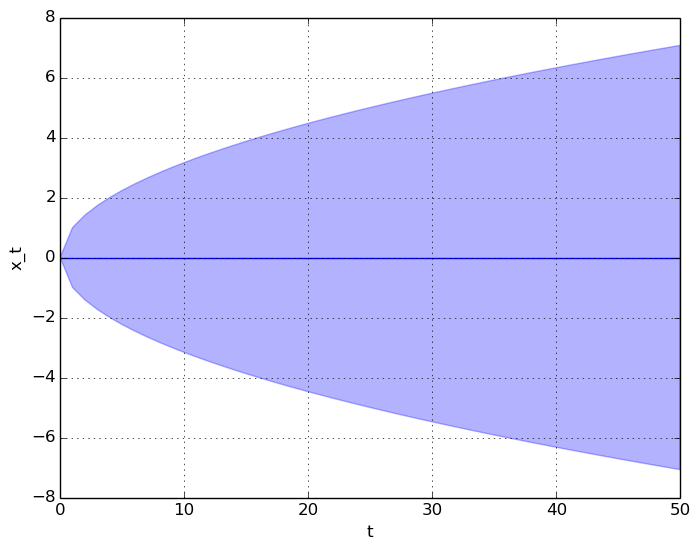

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


PyObject <matplotlib.text.Text object at 0x7f949cc49c50>

In [6]:
using PyPlot

# Make plot
plot(collect(0:T), [x_m_0; x_m], "b-")
fill_between(collect(0:T), [x_m_0; x_m]-sqrt([x_v_0; x_v]), [x_m_0; x_m]+sqrt([x_v_0; x_v]), color="b", alpha=0.3)
grid("on")
xlabel("t")
ylabel("x_t")